In [ ]:
#### 
# Created by Ewerton Lopes
# Politecnico di Milano, December, 2016.

In [1]:
from __future__ import division
%matplotlib inline
import csv
import sys
import os
import traceback
import json
import numpy as np
import pandas as pd
from tabulate import tabulate
from pandas.tools.plotting import lag_plot, autocorrelation_plot
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
from scipy.stats import norm, skew, kurtosis
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR
import scipy.fftpack as fft

from helper_functions import getListOfFiles, getCSV, getStatistics, remap_interval

## Loading dataset

Let's load the csv files, that together comprise the our dataset, from the `.data` directory:

In [2]:
csv_dir = "../data/annotated_csv"
files = getListOfFiles(csv_dir, ".csv")
print ">> {} CSV Files found:\n".format(len(files))
print json.dumps(files)

>> 34 CSV Files found:

["_2016-11-23-18-49-13_exp1_Player.csv", "_2016-11-23-18-49-13_exp2_Player.csv", "_2016-11-23-18-49-13_exp3_Player.csv", "_2016-11-23-18-49-13_exp4_Player.csv", "_2016-11-23-18-49-13_exp5_Player.csv", "_2016-11-24-15-43-37_exp1d_Player.csv", "_2016-11-24-15-43-37_exp2d_Player.csv", "_2016-11-24-15-43-37_exp3d_Player.csv", "_2016-11-24-15-43-37_exp4d_Player.csv", "_2016-11-24-15-43-37_exp5d_Player.csv", "_2016-11-24-15-43-37_exp6d_Player.csv", "_2016-11-24-16-23-29_expa_Player.csv", "_2016-11-24-16-23-29_expb_Player.csv", "_2016-11-24-16-23-29_expc_Player.csv", "_2016-11-24-16-23-29_expd_Player.csv", "_2016-11-24-16-48-48_exp1d_Player.csv", "_2016-11-24-16-48-48_exp2d_Player.csv", "_2016-11-24-16-48-48_exp3d_Player.csv", "_2016-11-24-17-15-38_expa_Player.csv", "_2016-11-24-17-15-38_expb_Player.csv", "_2016-11-24-17-15-38_expc_Player.csv", "_2016-11-24-17-40-06_expb_Player.csv", "_2016-11-26-15-42-51_exp1d_Player.csv", "_2016-11-26-16-05-47_exp1d_Player.csv", "_20

## Data summary

In [3]:
# Get details about the data stored on the csv files.
%run data_summary.py -f ../data/annotated_csv

*****************************************************************
                         OVERALL SUMMARY
*****************************************************************

CSV dir: 	../data/annotated_csv
N.Files: 	34
Ref. overlap: 	50%
N. Windows (Avg): 	31.07
Overlap    (Avg): 	49.99%
Overlap    (Std) : 	0.04%
Overpap dev. from ref. (Avg): 	-0.01%
Overpap dev. from ref. (Std): 	0.04%

Topic                              Avg #Samples per Windows    Std
-------------------------------  --------------------------  -----
Control                                              182.72  24.06
robogame/imu_state.linear_acc.x                      138.18  24.51
robogame/imu_state.linear_acc.z                      138.18  24.51
robogame/imu_state.gyro.z                            138.18  24.51
robogame/imu_state.gyro.x                            138.18  24.51
robogame/imu_state.linear_acc.y                      138.18  24.51
robogame/imu_state.gyro.y                            138.18  24.51
Expect

## Plot functions:

In [22]:
def pdf(data,suptitle="PDF fitting", headers="", normalize_data=False):
    """Plot the probability density function.
    Args:
        data (list: pd.Series): the list of data to be used.
        headers (list: str)   : list of titles for the plots
        normalize_data : normalize data prior to fit the pdf.
    """

    grid_side_size = int(round(np.sqrt(len(data))))
    #fig = plt.figure(figsize=(11,7))
    fig, axes = plt.subplots(grid_side_size, grid_side_size, figsize=(18,12))
    
    count = 0
    for i, row in enumerate(axes):
        for j in range(grid_side_size):
            if count >= len(data):
                break
                
            #normalize vector
            if normalize_data:
                n_data = data[count]/data[count].sum()
            else:
                n_data = data[count]
                
            # Fit a normal distribution to the data:
            mu, sigma = norm.fit(n_data)
            
            if headers == "":
                row[j].set_title("{}-Fit. mu={:.2f},  std={:.2f}".format(count, mu, sigma), fontsize=8)
            else:
                row[j].set_title("Fit for {}. mu={:.2f},  std={:.2f}".format(headers[count], mu, sigma), fontsize=8)
            
            # Using the  Freedman-Diaconis rule for getting the number of bins
            bin_size = 2 * iqr(n_data) * len(n_data) ** (-1 / 3)
            bins = int(round((max(n_data) - min(n_data)) / bin_size))

            # Plot the histogram.
            bin_value, bin_edges, p = row[j].hist(n_data, bins=bins, normed=True, alpha=0.6, color='g')
            
            # Normalizing heights
            #debug = 0
            #for i, item in enumerate(p):
            #    debug += (bin_value[i] / sum(bin_value*np.diff(bin_edges)))
            #    item.set = bin_value[i]/ sum(bin_value*np.diff(bin_edges))
            #print debug

            # Plot the PDF.
            xmin, xmax = row[j].get_xlim()
            x = np.linspace(xmin, xmax, 100)
            p = norm.pdf(x, mu, sigma)
            row[j].plot(x, p, 'k', linewidth=2, color='r')
            count += 1

    fig.suptitle(suptitle, fontsize=21)
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.draw()

def gridOfPlots(data, columnToPlot, feature='activity', suptitle="Grid of plot"):
    """Plots the data in a grid of plots.
    Args:
        data (list): the list of data to be used.
        title (str): grid title.
        columnToPlot: the column in the data to be plotted.
    """
    
    grid_side_size = int(round(np.sqrt(len(data))))
    fig, axes = plt.subplots(grid_side_size, grid_side_size, figsize=(18,12))

    count = 0
    for i, row in enumerate(axes):
        for j in range(grid_side_size):
            if count >= len(data):
                fig.delaxes(row[j])
            else:
                #norm_data = [remap_interval(x,-32768,32768,0,1) for x in data[count][columnToPlot].dropna()]
                ## According to the MPU-6050 datasheet, page 13, you can convert the raw accelerometer
                # data into multiples of g (9.8 m/s^2) by dividing by a factor of 16384. 
                norm_data = [x/16384.0 for x in data[count][columnToPlot].dropna()]
                row[j].set_title("W={}. {}={} ".format(count,feature, data[count][feature][0]), fontsize=8, fontweight="bold")
                row[j].set_ylabel('g\'s (9.8 m/s^2)')
                row[j].plot(norm_data, label=str(data[count]["high_level"][0]))
                row[j].grid()
                count += 1

    fig.suptitle(suptitle, fontsize=21)
    fig.subplots_adjust(hspace=0.5, wspace= 0.4)
    plt.draw()

def gridOfLagPlots(data, columnToPlot, suptitle="Plot"):
    """Plots a grid of plots corresponding to a lag-one time series 
    graph for the given column.
    
    The 'abscissa' correspond to the column value at time t. The 'ordinate' correspond
    to the column value at time t-1. Hence the name 'lag-one' time series plot.
    
    Args:
        data (list): the list of data to be used.
        title (str): grid title.
        columnToPlot: the column in the data to be plotted.
    """
    grid_side_size = int(round(np.sqrt(len(data))))
    plt.figure(figsize=(18,12))

    count = 0
    for i in range(grid_side_size):
        for j in range(grid_side_size):
            if count >= len(data):
                break
            plt.subplot(grid_side_size,grid_side_size,count+1)
            lag_plot(data[count][columnToPlot].dropna())
            plt.title("Windows-{}".format(count))
            count += 1


    plt.suptitle(suptitle, fontsize=21)
    plt.subplots_adjust(hspace=0.5, wspace= 0.4)
    plt.draw()
    
def plotAcc(data, suptitle="Accelerometer signal", feature= 'High_level', plt_win_func=False):
    """Plots the data in a grid of plots.
    Args:
        data (list): the list of data to be used.
        title (str): grid title.
        columnToPlot: the column in the data to be plotted.
    """
    
    grid_side_size = int(round(np.sqrt(len(data))))
    fig, axes = plt.subplots(grid_side_size, grid_side_size, figsize=(18,12))

    count = 0
    for i, row in enumerate(axes):
        for j in range(grid_side_size):
            if count >= len(data):
                fig.delaxes(row[j])
            else:
                ## According to the MPU-6050 datasheet, page 13, you can convert the raw accelerometer
                # data into multiples of g (9.8 m/s^2) by dividing by a factor of 16384. 
                norm_dataX = [x/16384.0 for x in data[count]["accX"].dropna()]
                norm_dataY = [y/16384.0 for y in data[count]["accY"].dropna()]
                norm_dataZ = [z/16384.0 for z in data[count]["accZ"].dropna()]

                row[j].set_title("W={}. {}={} ".format(count, feature, data[count][feature][0]), fontsize=8, fontweight="bold")
                row[j].set_ylabel('g\'s (9.8 m/s^2)')
                row[j].set_ylim((-1,1))
                row[j].set_xlim((0,len(norm_dataX)))
                row[j].plot(norm_dataX, label="x")
                row[j].plot(norm_dataY, label="y")
                row[j].plot(norm_dataZ, label="z")
                # draw a default vline at x=1 that spans the yrange
                row[j].axvline(x=len(norm_dataX)/2, color='g', marker='.')
                row[j].grid()
                count += 1
                row[j].legend(loc='upper center', bbox_to_anchor=(0.5, 1.45), ncol=3, fontsize=8, fancybox=True, shadow=True)
    
    fig.suptitle(suptitle, fontsize=21)
    fig.subplots_adjust(hspace=0.7, wspace= 0.5)
    plt.draw()

# EXPLORATORY DATA ANALYSIS

Now, we define a dictionary containing a remap of the name of the features. This is to easy visualization since ros feature names may be very long and also allow quick decoupled modifications (just edit the variable locally). Also, from it we define a ignore list containing the names we do not want to consider for the analysis. That is done by setting to the ignore list all dictionary keys with empty values. **Here we assume the names are consistent feature name w.r.t. the `csv` data. Otherwise, a `ValueError` exception is likely to be thrown!**

In [5]:
# variable for storing the loaded feature names.
feature_name_map = {
  "time" : "time",
  "Control": "control",
  "High_level": "high_level",
  "Expectation": "expectation",
  "Activity": "activity",
  "/kinect_features/.ci": "ci",
  "/kinect_features/.distance": "distance",
  "/kinect_features/.proximity": "proximity",
  "robogame/imu_state.gyro.x": "gyroX",
  "robogame/imu_state.gyro.y": "gyroY",
  "robogame/imu_state.gyro.z": "gyroZ",
  "robogame/imu_state.linear_acc.x": "accX",
  "robogame/imu_state.linear_acc.y": "accY",
  "robogame/imu_state.linear_acc.z": "accZ"
}

ignore_col_list = [k for k,v in feature_name_map.items() if v is ""]
print "List of ignored topics: {}".format(ignore_col_list)

List of ignored topics: []


## Load data

We begin the analysis using only one file. Of course, once it is completed, we extend the analysis for the other files in the list.

In [16]:
from helper_functions import getListOfFiles, getCSV, getStatistics, remap_interval

In [17]:
##NOTE: IF "TOO MANY VALUES TO UNPACK" ERROR IN THE getCSV METHOD, RESTART THE KERNEL. SOMETHING MUST BE WRONG WITH
# THE KERNEL INITIALIZATION. MUST BE CHECKED! (LOW-PRIORITY)

csv_filename = files[1]  # get only the fist loaded csv file.
csv_data = None          # the variable where the loaded csv data is stored.
num_windows = 0          # the number of windows loaded.
wFrames = []             # the list of windows data. Each element is a pandas dataframe 
                         #  corresponding to the windows. The list is of size 'num_windows'.

print 'Processing: "{}"'.format(csv_filename)

# load the data, abort in case of error.
try:
    num_windows, csv_data = getCSV(os.path.join(csv_dir, csv_filename))
except ValueError as e:
    print traceback.format_exc()
    sys.exit(-1)

for w in range(num_windows):
    win_data = {}
    for k in csv_data.keys():
        # consider the data only if it is not in the ignore list.
        if k not in ignore_col_list:
            win_data[feature_name_map[k]] = csv_data[k][w]

    # convert dictionary to dataframe and save it to list of all windows data for the file.
    wFrames.append(pd.DataFrame.from_dict(win_data))
print 'Retrieved {} windows in {}'.format(num_windows, csv_filename)
overlap_reference = 50
_, n_windows, sample_info, avg_overlap, avg_diff = getStatistics(csv_data, compareWith=overlap_reference)

print "LOAD SUMMARY:"
print tabulate([[n_windows,"{:.2f}".format(avg_overlap),"{:.2f}".format(avg_diff)]],
                   headers=["#Win", "Avg. Overlap", "Avg. dev. from ref."])

Processing: "_2016-11-23-18-49-13_exp2_Player.csv"
Retrieved 28 windows in _2016-11-23-18-49-13_exp2_Player.csv
LOAD SUMMARY:
  #Win    Avg. Overlap    Avg. dev. from ref.
------  --------------  ---------------------
    28           49.97                  -0.03


## Plotting the accelerometer signal

In [18]:
def accmag(data, suptitle="Magnitude of accelerometer signal", feature='High_level', plt_win_func=False):
    """Plots the data in a grid of plots.
    Args:
        data (list): the list of data to be used.
        title (str): grid title.
        columnToPlot: the column in the data to be plotted.
    """
    
    grid_side_size = int(round(np.sqrt(len(data))))
    fig, axes = plt.subplots(grid_side_size, grid_side_size, figsize=(18,12))

    count = 0
    for i, row in enumerate(axes):
        for j in range(grid_side_size):
            if count >= len(data):
                fig.delaxes(row[j])
            else:
                ## According to the MPU-6050 datasheet, page 13, you can convert the raw accelerometer
                # data into multiples of g (9.8 m/s^2) by dividing by a factor of 16384. 
                norm_dataX = [x/16384.0 for x in data[count]["accX"].dropna()]
                norm_dataY = [y/16384.0 for y in data[count]["accY"].dropna()]
                norm_dataZ = [z/16384.0 for z in data[count]["accZ"].dropna()]

                mag = []
                for i in range(len(norm_dataX)):
                    mag.append(np.sqrt(norm_dataX[i]**2 + norm_dataY[i]**2 + norm_dataZ[i]**2))

                windowFunction = np.hanning(len(mag))
                #if use_win_func:
                #    mag = mag * np.hanning(len(mag))

                row[j].set_title("W={}. {}={} ".format(count, feature, data[count][feature][0]), fontsize=8, fontweight="bold")
                row[j].set_ylabel('Vector magnitude')
                row[j].plot(mag, label=str(data[count][feature][0]))
                row[j].plot(windowFunction, label="hanning")
                row[j].grid()
                if plt_win_func:
                    row[j].plot(mag * np.hanning(len(mag)), label="combined")
                count += 1
                row[j].legend(loc='upper center', bbox_to_anchor=(0.5, 1.45), ncol=3, fontsize=8, fancybox=True, shadow=True)
    
    fig.suptitle(suptitle, fontsize=21)
    fig.subplots_adjust(hspace=0.7, wspace= 0.5)
    plt.draw()
    
    
def running_mean(l, N):
    # Also works for the(strictly invalid) cases when N is even.
    if (N//2)*2 == N:
        N = N - 1
    front = np.zeros(N//2)
    back = np.zeros(N//2)

    for i in range(1, (N//2)*2, 2):
        front[i//2] = np.convolve(l[:i], np.ones((i,))/i, mode = 'valid')
    for i in range(1, (N//2)*2, 2):
        back[i//2] = np.convolve(l[-i:], np.ones((i,))/i, mode = 'valid')
    return np.concatenate([front, np.convolve(l, np.ones((N,))/N, mode = 'valid'), back[::-1]])

def compute_runavg_acc(data, suptitle="Running average smoothing", feature='activity', N=4):
    """Running average as smoothing"""
    grid_side_size = int(round(np.sqrt(len(data))))
    fig, axes = plt.subplots(grid_side_size, grid_side_size, figsize=(18,12))

    count = 0
    for i, row in enumerate(axes):
        for j in range(grid_side_size):
            if count >= len(data):
                fig.delaxes(row[j])
            else:
                ## According to the MPU-6050 datasheet, page 13, you can convert the raw accelerometer
                # data into multiples of g (9.8 m/s^2) by dividing by a factor of 16384. 
                norm_dataX = [x/16384.0 for x in data[count]["accX"].dropna()]
                norm_dataX = running_mean(norm_dataX, N)
                norm_dataY = [y/16384.0 for y in data[count]["accY"].dropna()]
                norm_dataY = running_mean(norm_dataY, N)
                norm_dataZ = [z/16384.0 for z in data[count]["accZ"].dropna()]
                norm_dataZ = running_mean(norm_dataZ, N)

                row[j].set_title("W={}. {}={} ".format(count, feature, data[count][feature][0]), fontsize=8, fontweight="bold")
                row[j].set_ylabel('g\'s (9.8 m/s^2)')
                row[j].plot(norm_dataX, label="x")
                row[j].plot(norm_dataY, label="y")
                row[j].plot(norm_dataZ, label="z")
                row[j].grid()
                count += 1
                row[j].legend(loc='upper center', bbox_to_anchor=(0.5, 1.45), ncol=3, fontsize=8, fancybox=True, shadow=True)
                
    fig.suptitle(suptitle + " -- Order=" + str(N), fontsize=21)
    fig.subplots_adjust(hspace=0.7, wspace= 0.5)
    plt.draw()

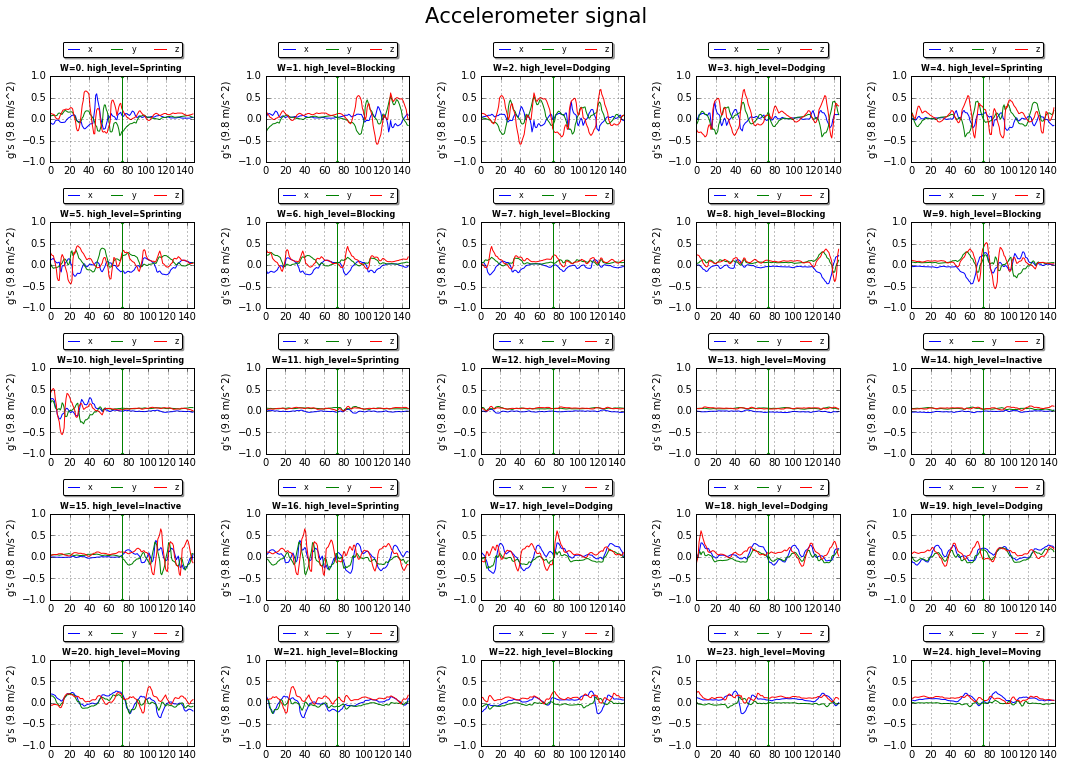

In [24]:
plotAcc(wFrames, feature='high_level')
#accmag(wFrames, plt_win_func=True)
#compute_runavg_acc(wFrames, N=8)